# Dataset analysis 

In [37]:
import numpy as np
import math
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from typing import List, Dict
import seaborn as sns
import json
from matplotlib import cm
from pprint import pformat
import json

import tikzplotlib

from torchvision import transforms
from PIL import Image as Img

from IPython.display import Image 

plt.style.use("seaborn")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [38]:
def load_json(filename : str) -> Dict:
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

In [39]:
base_path_raw = os.path.abspath('/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/')
model_folders = [os.path.join(base_path_raw, o) for o in os.listdir(base_path_raw) if os.path.isdir(os.path.join(base_path_raw,o)) and not o.startswith('.')]

In [40]:
model_folders

['/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/12b1beb780062c34dd2482eb02e705e2',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/309402cd6123961fdd1a827faafdea05',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/edc036f241e350ed66b07d6edebaaef2',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/365ae50c5f1f0a7320a2db9e99cd5cc8',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/f47727dbebdcd1b5f568e0217fcad821',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/0c30cf5d2687230bfb3d20b4e332ab71',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/ab60e3fb01ac94277d5b75f445473d42',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/16ad1271ac0f9f11c79a6d9e2b3cd8a4',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/40a108b1126422e410beedb74aa11453',
 '/media/jan/MastatJan/temp/results_full_dataset_2_contrast_3/e7c206f34d8805ec23b679297ef284e0',
 '/media/jan/MastatJan/temp/re

In [41]:
folder = model_folders[0]
result = load_json(os.path.join(folder, r'score_dict_final.json'))
exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
result.update({
    'model_base' : exp_dict['model']['base'],
    'context_span' : exp_dict['dataset']['context_span'],
    'loss' : exp_dict['model']['loss']
})

result

{'train_score': 0.9218780815579836,
 'train_weighted_dice': 0.9060430504144016,
 'val_score': 0.7125415387627144,
 'val_weighted_dice': 0.65084917726221,
 'train_loss': 0.005426482817649241,
 'epoch': 15,
 'waiting': 4,
 'test_dice': 0.7045384860494858,
 'test_weighted_dice': 0.6456995348996643,
 'test_iou': 0.5640591275929999,
 'test_prec': 0.6692913673441939,
 'test_recall': 0.7491003927878488,
 'test_score': 0.7045384860494858,
 'model_base': 'unet2d',
 'context_span': 3,
 'loss': 'cross_entropy'}

In [42]:
result = list()
for folder in model_folders:
    r = load_json(os.path.join(folder, r'score_dict_final.json'))
    exp_dict = load_json(os.path.join(folder, f'exp_dict.json'))
    r.update({
        'model_base' : exp_dict['model']['base'],
        'context_span' : exp_dict['dataset']['context_span'],
        'loss' : exp_dict['model']['loss'],
        'foldername' : folder.split('/')[-1]
    })
    result.append(r)

result = pd.DataFrame(result).sort_values(['test_weighted_dice', 'test_dice'], ascending = False)
result

,train_score,train_weighted_dice,val_score,val_weighted_dice,train_loss,epoch,waiting,test_dice,test_weighted_dice,test_iou,test_prec,test_recall,test_score,model_base,context_span,loss,foldername
2,0.961236,0.953535,0.812707,0.773316,0.002601,49,0,0.801245,0.758672,0.680605,0.750694,0.867133,0.801245,fcn8_vgg16,0,cross_entropy,edc036f241e350ed66b07d6edebaaef2
11,0.948136,0.937654,0.796303,0.753627,0.003491,22,4,0.797494,0.752692,0.677485,0.741776,0.870374,0.797494,fcn8_vgg16,1,cross_entropy,dfaeaf1bd9747b2b0d135fd495f699ec
16,0.933321,0.919967,0.799074,0.756370,0.004516,15,4,0.790756,0.744971,0.668116,0.730645,0.867050,0.790756,fcn8_vgg16,3,cross_entropy,b1292d31b739d2327982349d5f6b27e8
12,0.920350,0.904357,0.759678,0.707821,0.005402,13,4,0.768394,0.719089,0.639314,0.728956,0.814906,0.768394,fcn8_resnet,1,cross_entropy,3ce60ea3c13d67ff7334beb1be210603
14,0.949649,0.939653,0.746864,0.693197,0.003500,27,4,0.761630,0.713119,0.631065,0.726637,0.803973,0.761630,unet2d,1,cross_entropy,6ab04a2154becb82b23e49700c9d2396
15,0.929930,0.915982,0.750290,0.695581,0.004743,19,4,0.765448,0.712101,0.640787,0.708914,0.838177,0.765448,fcn8_resnet,3,cross_entropy,4c21df3fe5f18164f1123cbd03edea2b
1,0.941394,0.929729,0.768668,0.720168,0.004283,22,4,0.753172,0.702805,0.620186,0.723951,0.786397,0.753172,unet2d,0,cross_entropy,309402cd6123961fdd1a827faafdea05
9,0.932683,0.919311,0.740436,0.685414,0.004436,23,4,0.729281,0.669526,0.597403,0.694921,0.771860,0.729281,fcn8_resnet,0,cross_entropy,e7c206f34d8805ec23b679297ef284e0
0,0.921878,0.906043,0.712542,0.650849,0.005426,15,4,0.704538,0.645700,0.564059,0.669291,0.749100,0.704538,unet2d,3,cross_entropy,12b1beb780062c34dd2482eb02e705e2
17,0.716493,0.659557,0.677472,0.613272,0.013981,29,4,0.695856,0.634695,0.553862,0.914524,0.576817,0.695856,fcn8_vgg16,3,weighted_cross_entropy,26aa087080bfa4fb5a6602d6fda8757d


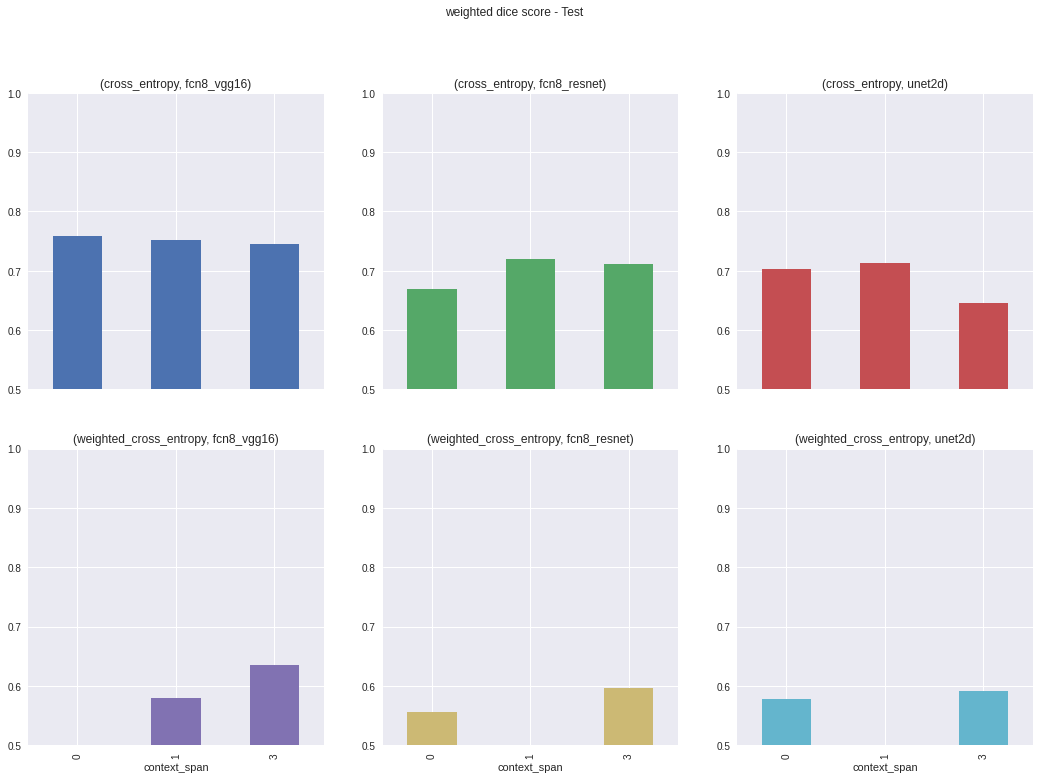

In [43]:
test_wd = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'test_weighted_dice')
test_wd.applymap(lambda x : round(x, 2)).to_html('test_wd.html')
test_wd.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('weighted dice score - Test')
plt.savefig('test_wd.png')

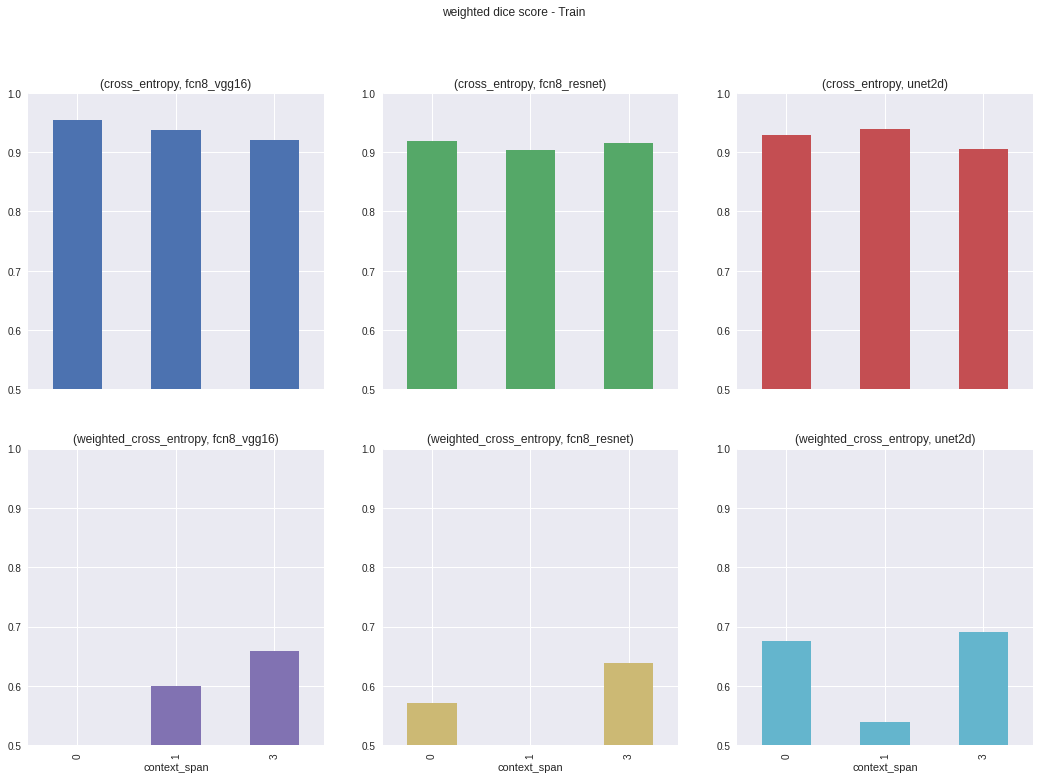

In [44]:
train_wd = result.pivot(index = 'context_span', columns = ['loss', 'model_base'], values = 'train_weighted_dice')
train_wd.applymap(lambda x : round(x, 2)).to_html('train_wd.html')
train_wd.plot(kind='bar', subplots = True, layout = (2, 3), legend = False, figsize = (18, 12), ylim = (0.5, 1))
plt.suptitle('weighted dice score - Train')
plt.savefig('train_wd.png')

<AxesSubplot:xlabel='epoch'>

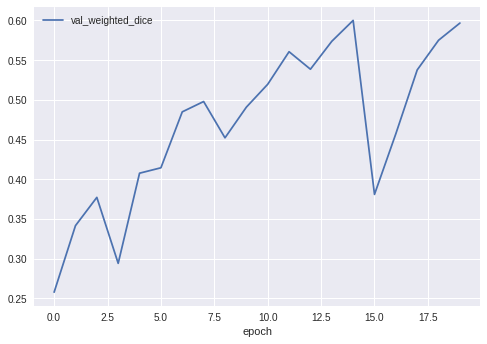

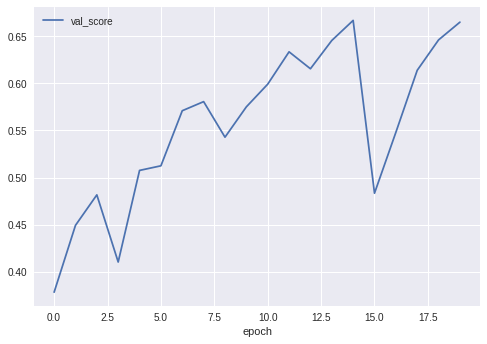

In [45]:
foldername = result.query("context_span == 3 & loss == 'weighted_cross_entropy' & model_base == 'fcn8_resnet'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')

<AxesSubplot:xlabel='epoch'>

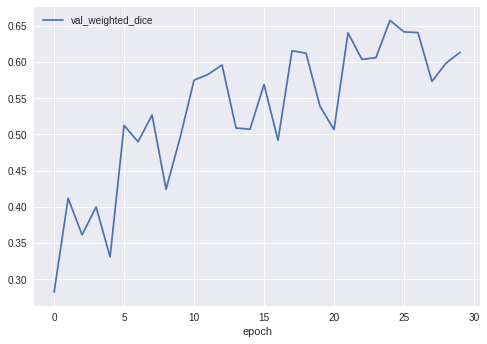

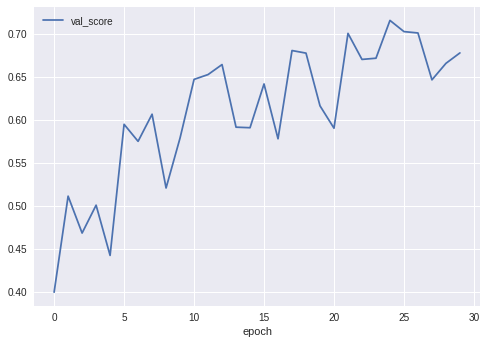

In [48]:
foldername = result.query("context_span == 3 & loss == 'weighted_cross_entropy' & model_base == 'fcn8_vgg16'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')

<AxesSubplot:xlabel='epoch'>

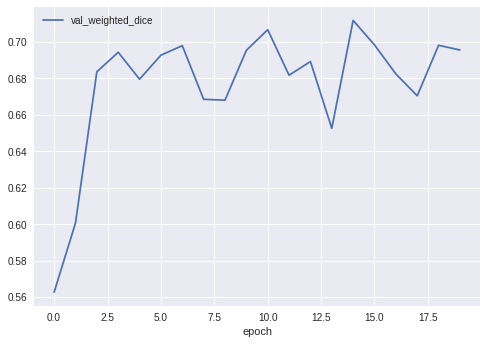

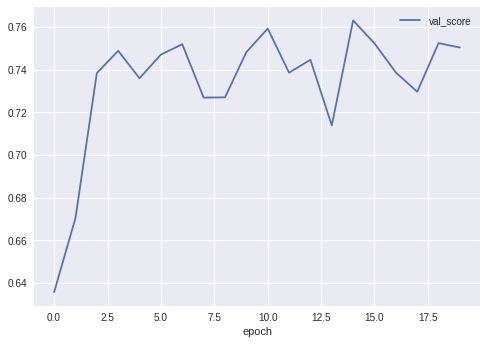

In [46]:
foldername = result.query("context_span == 3 & loss == 'cross_entropy' & model_base == 'fcn8_resnet'").foldername.iloc[0]
score_df = pd.read_csv(os.path.join(base_path_raw, foldername, 'score_df.csv'), index_col=0)
score_df.plot(x = 'epoch', y = 'val_weighted_dice')
score_df.plot(x = 'epoch', y = 'val_score')